In [1]:
from sklearn.cluster import KMeans
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
#Load Data
df_2017_2020 = pd.read_csv(".//wind_power_data_2017_2020.csv")
df_2017_2020.head()

,Wind_turbine_name,Date_time,Ba,Rt,DCs,Cm,P,Q,S,Cosphi,...,Ws2,Ws,Wa,Va,Ot,Nf,Nu,Rs,Rbt,Rm
0,R80721,2017/2/8 12:40,44.990002,14.860000,88.279999,3.10,-3.080000,0.010000,3.090000,1.00,...,1.95,1.90,343.280000,25.180000,5.30,49.980000,703.00000,0.84,21.040001,-336.720000
1,R80721,2017/2/8 14:40,44.990002,14.000000,23.320000,2.40,-1.810000,0.000000,1.810000,1.00,...,0.24,0.20,2.430000,44.310001,4.89,49.990002,704.63000,0.14,19.230000,0.000000
2,R80721,2017/2/8 15:00,44.990002,14.000000,38.369999,2.39,-1.890000,0.000000,1.890000,1.00,...,0.22,0.18,358.049990,39.939999,4.80,50.000000,698.40002,0.33,19.020000,-18.889999
3,R80721,2017/1/26 05:30,-1.000000,10.340000,1208.040000,1802.37,199.350010,16.389999,200.050000,1.00,...,5.42,4.91,61.540001,-1.900000,-6.42,50.009998,698.78003,11.52,23.000000,1571.050000
4,R80721,2017/1/26 07:40,-1.000000,9.979999,1005.250000,1171.28,92.589996,14.220000,93.709999,0.99,...,4.67,4.20,72.010002,8.530000,-7.30,50.000000,695.23999,9.58,21.459999,877.039980


In [13]:
#Filter Data
df_2017_2020 = df_2017_2020[["Wind_turbine_name", "Ba", "P", "Ws"]]
R80721_R80790_df = df_2017_2020[df_2017_2020.Wind_turbine_name.apply(lambda x: x in ('R80721', 'R80790'))]
R80721_R80790_df.dropna(inplace=True)
R80721_R80790_df.head

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<bound method NDFrame.head of        Wind_turbine_name         Ba           P    Ws
0                 R80721  44.990002   -3.080000  1.90
1                 R80721  44.990002   -1.810000  0.20
2                 R80721  44.990002   -1.890000  0.18
3                 R80721  -1.000000  199.350010  4.91
4                 R80721  -1.000000   92.589996  4.20
...                  ...        ...         ...   ...
217583            R80790  -1.000000  143.350000  4.72
217584            R80790  -0.810000   58.100000  4.05
217585            R80790  -1.000000   72.130000  4.36
217586            R80790  -1.000000   78.060000  4.60
217587            R80790  -1.000000  109.640000  4.72

[108100 rows x 4 columns]>

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


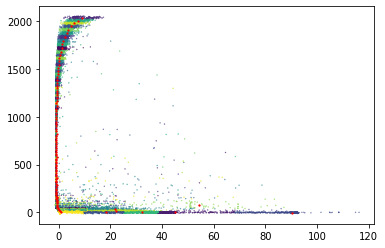

In [27]:
#Create Model
CLUSTER_NUMBER = 100
kmeans = KMeans(CLUSTER_NUMBER)

kmeans.fit(R80721_R80790_df[["Ba", "P"]])
R80721_R80790_df['group'] = kmeans.predict(R80721_R80790_df[["Ba", "P"]])

# scatter cluster
plt.scatter(
    R80721_R80790_df.Ba, 
    R80721_R80790_df.P, 
    c=R80721_R80790_df['group'], 
    s=0.1)
# plot center
for center in kmeans.cluster_centers_:
    plt.scatter(center[0], center[1], c='red', s=1.5)

In [28]:
R80721_R80790_df.group

0          8
1          8
2          8
3         37
4         42
          ..
217582    14
217583    98
217584    56
217585    26
217586    84
Name: group, Length: 108099, dtype: int32

In [5]:
#define function of Normalize
def Normalize(values, method = "minmax"):
    if method == 'minmax':
        min_value = values.min()
        max_value = values.max()
        func = lambda x: (x - min_value) / (max_value - min_value)
    elif method == 'zscore':
        mean = values.mean()
        std = values.std()
        func = lambda x: (x - mean) / std
    else:
        func = lambda x: x
        
    return values.apply(func)

In [6]:
#def distance
def Distance2(x1, y1, x2, y2):
    return (x1 - x2)**2 + (y1 - y2)**2

In [33]:
#According to power and wind_speed, Suggest wind_turbine angle by knn model 
def SuggestAngleByKNN(data, power, wind_speed, n_neighbors=5):   
    #normaliztion
    std_data = data.append({"P": power, "Ws":wind_speed}, ignore_index=True)
    std_data["std_power"] = Normalize(std_data.P)
    std_data["std_wind_speed"] = Normalize(std_data.Ws)
    std_power = std_data["std_power"].iloc[-1]
    std_wind_speed = std_data["std_wind_speed"].iloc[-1]
    std_data.drop(index=std_data.tail(1).index, inplace=True)

    #Distance
    std_data['distance'] = std_data.apply(lambda x: Distance2(x['std_power'], x['std_wind_speed'], \
                                                              std_power, std_wind_speed), axis=1)
    # Get number of k colse point
    kpoints = std_data.loc[std_data.distance.nsmallest(n_neighbors).index]

    # find number of the group appeard the most
    group = Counter(kpoints.group).most_common(1)[0][0]
    
    # Mean
    std_data = std_data[std_data.group==group]
    angle = std_data.Ba.mean()
    
    return angle

In [34]:
#Test 1
SuggestAngleByKNN(R80721_R80790_df, 20, 1)

0.49818586803309894

In [36]:
#Test 2
SuggestAngleByKNN(R80721_R80790_df, 0, 0)

45.0038855246864

In [37]:
#Test 3
SuggestAngleByKNN(R80721_R80790_df, 43, 23)

90.51335640420868